In [1]:
import os, sys
import numpy as np
import h5netcdf

import xarray as xr
import xarray.ufuncs as xu
import pandas as pd
import xrft

from matplotlib import pyplot as plt
import cartopy.crs as ccrs
import cartopy

plt.rc("figure", figsize=(18,8))
plt.rc("font", size=14)
ccrs.PlateCarree()

from dask.diagnostics import ProgressBar
from dask.distributed import Client, LocalCluster
cluster = LocalCluster(processes=False, n_workers=1, threads_per_worker=8)
client = Client(cluster)
client



Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://137.129.155.67:8787/status,
Dashboard: http://137.129.155.67:8787/status,Workers: 1
Total threads: 8,Total memory: 78.61 GiB
Status: running,Using processes: False
Comm: inproc://137.129.155.67/15588/1,Workers: 1
Dashboard: http://137.129.155.67:8787/status,Total threads: 8
Started: Just now,Total memory: 78.61 GiB
Comm: inproc://137.129.155.67/15588/3,Total threads: 8
Dashboard: http://137.129.155.67:47357/status,Memory: 78.61 GiB
Nanny: None,


In [2]:
indir_anom = '/cnrm/tropics/commun/DATACOMMUN/WAVE/NO_SAVE/DATA/RAW_ANOMALY/OLR/'
filenames = np.arange(2001,2020)
datasets = []
for f in filenames:
    if f == 2013 :
        continue
    ds = xr.open_mfdataset(indir_anom + '*'+str(f)+'*.nc', chunks={'time': None,'latitude' : 1}, engine='h5netcdf')
    datasets.append(ds)
ds = xr.concat(datasets, dim='time', coords='minimal', compat='override')
ds

<xarray.Dataset>
Dimensions:  (time: 52592, lon: 360, lat: 60)
Coordinates:
  * time     (time) datetime64[ns] 2001-01-01 ... 2019-12-31T21:00:00
  * lon      (lon) float32 0.5 1.5 2.5 3.5 4.5 ... 355.5 356.5 357.5 358.5 359.5
  * lat      (lat) float32 -29.5 -28.5 -27.5 -26.5 -25.5 ... 26.5 27.5 28.5 29.5
Data variables:
    OLR_ano  (time, lat, lon) float64 dask.array<chunksize=(2920, 60, 360), meta=np.ndarray>

In [3]:
indir_anom = '/cnrm/tropics/commun/DATACOMMUN/WAVE/NO_SAVE/DATA/RAW_ANOMALY/TCWV/'
indir_TF = '/cnrm/tropics/commun/DATACOMMUN/WAVE/NO_SAVE/DATA/TF2D/OLR/'

year = np.arange(2001,2020)
datasets = []
for f in year:
    print(f)
    if f == 2013 :
        continue
    ds = xr.open_mfdataset(indir_TF + '*'+str(f)+'*.nc', chunks={'freq_time' : 1, 'lat' : 8}, engine='h5netcdf')
    ds = ds.sel(time=str(f), lat = slice(-15, 15))
    datasets.append(ds)
ds = xr.concat(datasets, dim ='time', coords='minimal', compat='override')
# ds = xr.open_mfdataset(indir_TF + '*'+str(2004)+'*.nc', chunks={'time': 1, 'latitude' : 1}, engine='h5netcdf')

ds

2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019


,Array,Chunk
Bytes,139.79 TiB,257.34 MiB
Shape,"(52592, 16913, 30, 360)","(2928, 2, 8, 360)"
Count,7764462 Tasks,1522080 Chunks
Type,complex128,numpy.ndarray


In [4]:
tcwvhat = (xu.conj(ds)*ds).real
tcwvhat

,Array,Chunk
Bytes,69.90 TiB,128.67 MiB
Shape,"(52592, 16913, 30, 360)","(2928, 2, 8, 360)"
Count,12330702 Tasks,1522080 Chunks
Type,float64,numpy.ndarray


In [5]:
# ds = ds.chunk({'time' : None, 'lat' : 1})
# with ProgressBar():
#     tcwvhat = xrft.power_spectrum(ds['OLR_ano'],
#                              dim=['time','lon'], true_phase=False, true_amplitude=True)
# tcwvhat

# tcwvhat_density = (xu.conj(ds)*ds).real

In [6]:
radius = 6371e3
radian = tcwvhat['lat']*np.pi/180
radian
# _varhat = varhat.sel(latitude = l)
deg_to_m = 111110


wav_number = (2*np.pi*radius*np.cos(radian))/40075e3
minVal = (2*np.pi*radius*np.cos(radian))/20
minVal
# 1/tcwvhat.freq_longitude.values*111111
test = 1/(tcwvhat.freq_lon.values)*deg_to_m
valDeg = 1/minVal*deg_to_m
# np.min(valDeg)


/tmp/ipykernel_15588/742743228.py:12: RuntimeWarning: divide by zero encountered in true_divide
  test = 1/(tcwvhat.freq_lon.values)*deg_to_m


In [7]:
_tcwvhat = tcwvhat.where(tcwvhat.freq_time > 0, drop = True)
_tcwvhat = _tcwvhat.where(tcwvhat.freq_lon < valDeg, drop = True)
_tcwvhat = _tcwvhat.where(tcwvhat.freq_lon > -valDeg, drop = True)
_tcwvhat['freq_time'] = _tcwvhat['freq_time']*86400
_tcwvhat = _tcwvhat.where(_tcwvhat.freq_time < 0.6, drop = True)

# _tcwvhat = _tcwvhat.where(tcwvhat.freq_time < 1/(3600*100), drop = True)

# xr.where(tcwvhat.freq_longitude > 0.33,  0., tcwvhat )
waveN = (2*np.pi*radius)/(1/_tcwvhat.freq_lon.values*deg_to_m) 
_tcwvhat = _tcwvhat.assign_coords(wavenumber = ("freq_lon", waveN))
_tcwvhat

/home/durandy/miniconda3/envs/towel/lib/python3.9/site-packages/xarray/core/indexing.py:1226: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]
/home/durandy/miniconda3/envs/towel/lib/python3.9/site-packages/xarray/core/indexing.py:1226: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key

,Array,Chunk
Bytes,610.65 GiB,7.33 MiB
Shape,"(52592, 1267, 30, 41)","(2928, 1, 8, 41)"
Count,17143930 Tasks,114030 Chunks
Type,float64,numpy.ndarray


In [8]:
_tcwvhat = _tcwvhat.sel(lat = slice(-15, 15))#mean('latitude')
_tcwvhat = _tcwvhat.sum('lat')
_tcwvhat = _tcwvhat.sum('time')
_tcwvhat = xu.log10(_tcwvhat) 
_tcwvhat = _tcwvhat.load()
_tcwvhat

<xarray.Dataset>
Dimensions:     (freq_time: 1267, freq_lon: 41)
Coordinates:
  * freq_lon    (freq_lon) float64 -0.05556 -0.05278 -0.05 ... 0.05278 0.05556
  * freq_time   (freq_time) float64 0.001377 0.001379 0.001504 ... 0.5986 0.5992
    wavenumber  (freq_lon) float64 -20.02 -19.01 -18.01 ... 18.01 19.01 20.02
Data variables:
    TF_tcwv     (freq_time, freq_lon) float64 24.28 24.44 24.38 ... 23.77 23.82

In [30]:
from wrf import smooth2d
test = smooth2d(_tcwvhat['TF_tcwv'], 10,cenweight=2.0)
test.load()

<xarray.DataArray 'smooth_TF_tcwv' (freq_time: 1267, freq_lon: 41)>
array([[24.27828575, 24.43988605, 24.37902725, ..., 24.37563657,
        24.3122077 , 24.33125592],
       [24.69611286, 24.40054467, 24.37631029, ..., 24.35379311,
        24.39077108, 24.79885067],
       [23.51968918, 24.09196271, 24.27830234, ..., 24.2708646 ,
        24.10083124, 23.51717685],
       ...,
       [23.03312767, 23.52809657, 23.65870622, ..., 23.76485186,
        23.55096841, 22.80667128],
       [24.13091541, 23.7841734 , 23.72728935, ..., 23.8522316 ,
        23.87321287, 24.31814248],
       [23.68173762, 23.75169016, 23.7338425 , ..., 23.86242391,
        23.76888701, 23.81945942]])
Coordinates:
  * freq_lon    (freq_lon) float64 -0.05556 -0.05278 -0.05 ... 0.05278 0.05556
  * freq_time   (freq_time) float64 0.001377 0.001379 0.001504 ... 0.5986 0.5992
    wavenumber  (freq_lon) float64 -20.02 -19.01 -18.01 ... 18.01 19.01 20.02
Attributes:
    passes:     10
    cenweight:  2.0

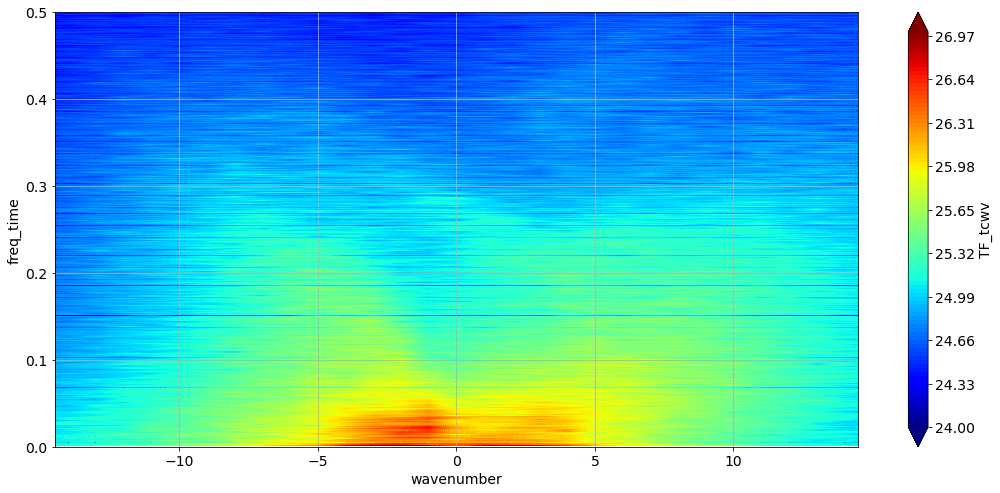

In [27]:


_tcwvhat.TF_tcwv.plot.contourf(x= "wavenumber", y = "freq_time", vmin=24, vmax=27, levels = 101, cmap= 'jet')
# plt.xaxes(_tcwvhat.wavenumber)
ax = plt.gca()
ax.set_xlim([-14.5, 14.5])
ax.set_ylim([0, .5])

plt.grid()

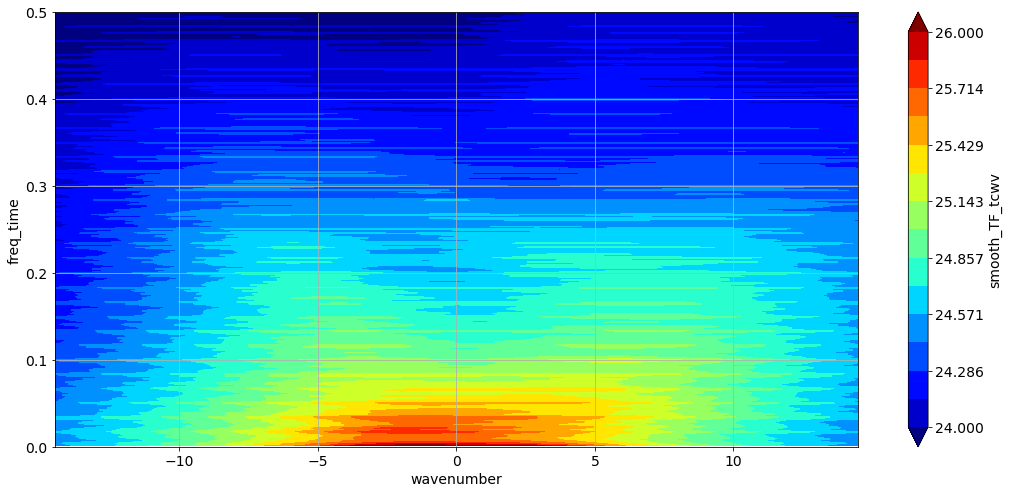

In [32]:
test.plot.contourf(x= "wavenumber", y = "freq_time", vmin=24, vmax=26, levels = 15, cmap= 'jet')
# plt.xaxes(_tcwvhat.wavenumber)
ax = plt.gca()
ax.set_xlim([-14.5, 14.5])
ax.set_ylim([0, .5])

plt.grid()